## Installing Required Libraries

This cell installs the necessary Python libraries for the project.

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import load_dataset
from peft import get_peft_model, LoraConfig, TaskType
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
## Load Tokenizer and Preprocess Dataimport pickle
from transformers import Trainer, TrainingArguments
from torch.optim import AdamW
import math
from torch.cuda.amp import autocast, GradScaler
import matplotlib.pyplot as plt

## Load Tokenizer and Preprocess Data

In [2]:
#  Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


# Load and preprocess AGNEWS dataset
dataset = load_dataset("ag_news")
train_ds=dataset['train']
eval_ds=dataset['test']
tokenizer = AutoTokenizer.from_pretrained("roberta-base")

def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=128)

tokenized_dataset = dataset.map(tokenize_function, batched=True)
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")
tokenized_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])


Using device: cuda


README.md:   0%|          | 0.00/8.07k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

## Load Pre-trained Model
Set up config for pretrained model and download it from hugging face

In [7]:
model = AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=4)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Setup LoRA Config
Setup PEFT config and get peft model for finetuning

In [8]:
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["query", "value"],
    lora_dropout=0.2,
    bias="none",
    task_type=TaskType.SEQ_CLS
)

model = get_peft_model(model, lora_config)
model.to(device)
model.print_trainable_parameters()

trainable params: 888,580 || all params: 125,537,288 || trainable%: 0.7078


## Display the trainable parameters and model

In [10]:
model

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): RobertaForSequenceClassification(
      (roberta): RobertaModel(
        (embeddings): RobertaEmbeddings(
          (word_embeddings): Embedding(50265, 768, padding_idx=1)
          (position_embeddings): Embedding(514, 768, padding_idx=1)
          (token_type_embeddings): Embedding(1, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): RobertaEncoder(
          (layer): ModuleList(
            (0-11): 12 x RobertaLayer(
              (attention): RobertaAttention(
                (self): RobertaSdpaSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=768, out_features=768, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.2, inplace=False)
                    )
                    (lora_A): Mod

In [5]:
print("Trainable parameters:")
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

Trainable parameters:
base_model.model.roberta.encoder.layer.0.attention.self.query.lora_A.default.weight
base_model.model.roberta.encoder.layer.0.attention.self.query.lora_B.default.weight
base_model.model.roberta.encoder.layer.0.attention.self.value.lora_A.default.weight
base_model.model.roberta.encoder.layer.0.attention.self.value.lora_B.default.weight
base_model.model.roberta.encoder.layer.1.attention.self.query.lora_A.default.weight
base_model.model.roberta.encoder.layer.1.attention.self.query.lora_B.default.weight
base_model.model.roberta.encoder.layer.1.attention.self.value.lora_A.default.weight
base_model.model.roberta.encoder.layer.1.attention.self.value.lora_B.default.weight
base_model.model.roberta.encoder.layer.2.attention.self.query.lora_A.default.weight
base_model.model.roberta.encoder.layer.2.attention.self.query.lora_B.default.weight
base_model.model.roberta.encoder.layer.2.attention.self.value.lora_A.default.weight
base_model.model.roberta.encoder.layer.2.attention.sel

## Training Setup
Define training arguments

In [32]:
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="no",
    learning_rate=1e-4,
    greater_is_better=True,    
    lr_scheduler_type="cosine",
    warmup_ratio=0.08,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    num_train_epochs=6,
    weight_decay=0.015,
    logging_dir="./logs",
    seed=2020,
    report_to="none"
)
optimizer = AdamW(model.parameters(), lr=training_args.learning_rate, weight_decay=0.01)
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {"accuracy": accuracy_score(labels, predictions)}

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [33]:
# Define optimizer separately
optimizer = AdamW(model.parameters(), lr=training_args.learning_rate, weight_decay=0.015)


### Starting Training

In [36]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    
)
#for r=4 and alpha=8
trainer.train()

<ipython-input-36-2c83e51a0bd4>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.229300,0.212281,0.926842
2,0.201700,0.191238,0.935921
3,0.185400,0.186833,0.940000
4,0.170600,0.182977,0.938289
5,0.179600,0.178450,0.940526
6,0.169000,0.178675,0.940395


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked t

TrainOutput(global_step=22500, training_loss=0.21680719638400608, metrics={'train_runtime': 7928.1184, 'train_samples_per_second': 90.816, 'train_steps_per_second': 2.838, 'total_flos': 4.777065234432e+16, 'train_loss': 0.21680719638400608, 'epoch': 6.0})

In [8]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    optimizers=(optimizer, scheduler)
)
#for r=8 and alpha=16
trainer.train()

<ipython-input-8-4005d0272124>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.241800,0.224123,0.922500
2,0.201500,0.193880,0.937368
3,0.186300,0.187517,0.939474
4,0.172200,0.182905,0.941053
5,0.178500,0.178867,0.941447
6,0.170500,0.179507,0.941974


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked t

TrainOutput(global_step=22500, training_loss=0.2191233652750651, metrics={'train_runtime': 8179.3266, 'train_samples_per_second': 88.027, 'train_steps_per_second': 2.751, 'total_flos': 4.785218961408e+16, 'train_loss': 0.2191233652750651, 'epoch': 6.0})

In [11]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()
#for r=16 and alpha=32

<ipython-input-11-4005d0272124>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.223000,0.210840,0.930921
2,0.202600,0.189327,0.937237
3,0.179700,0.185517,0.938947
4,0.170700,0.178594,0.941184
5,0.159200,0.177548,0.942763
6,0.149600,0.174520,0.943421


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked t

TrainOutput(global_step=22500, training_loss=0.2057590379503038, metrics={'train_runtime': 8566.9154, 'train_samples_per_second': 84.044, 'train_steps_per_second': 2.626, 'total_flos': 4.80152641536e+16, 'train_loss': 0.2057590379503038, 'epoch': 6.0})

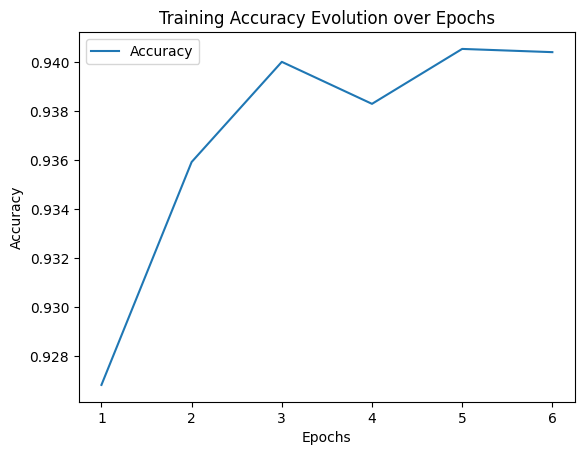

In [39]:
logs = trainer.state.log_history
accuracy_values = []

# Collect accuracy values at each evaluation
for log in logs:
    if 'eval_accuracy' in log:
        accuracy_values.append(log['eval_accuracy'])

# Plot accuracy over epochs
plt.plot(range(1, len(accuracy_values) + 1), accuracy_values, label="Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy Evolution over Epochs")
plt.legend()
plt.show()

In [9]:
# -----------------------------
# 7. Evaluate the model
# -----------------------------
eval_results = trainer.evaluate()
print("Final Evaluation Accuracy:", eval_results["eval_accuracy"])

/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Final Evaluation Accuracy: 0.9419736842105263


In [10]:
# -----------------------------
# 8. Check trainable parameter count
# -----------------------------
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params}")

Trainable parameters: 888580


### Run Inference on eval_dataset

In [9]:
from datasets import Dataset
from torch.utils.data import DataLoader

# Load dataset object
with open("/kaggle/input/deep-learning-spring-2025-project-2/test_unlabelled.pkl", "rb") as f:
    test_dataset = pickle.load(f)

# Convert to HuggingFace Dataset (already is, but this helps formatting)
test_dataset = Dataset.from_dict({"text": test_dataset["text"]})

# Tokenize function
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=128)

# Apply tokenizer
tokenized_test_dataset = test_dataset.map(preprocess_function, batched=True)
tokenized_test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask"])

# Create PyTorch DataLoader for batching
test_dataloader = DataLoader(tokenized_test_dataset, batch_size=64)

# Prediction loop
model.eval()
all_predictions = []

with torch.no_grad():
    for batch in test_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        preds = torch.argmax(outputs.logits, dim=-1)
        all_predictions.extend(preds.cpu().numpy())


Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

## Test on kaggle test dataset

The following code performs inference on the Kaggle test data

In [12]:
# -----------------------------
# 10. Save predictions to CSV
# -----------------------------
df = pd.DataFrame({
    "ID": list(range(len(all_predictions))),   # ID ✅
    "label": all_predictions
})
df.to_csv("submission.csv", index=False)
print("✅ Batched predictions complete. Saved to submission.csv.")

✅ Batched predictions complete. Saved to submission.csv.
